In [2]:
%load_ext autoreload
%autoreload 2

import sys
import lightning.pytorch as pl
import torch
from matplotlib import pyplot as plt
import numpy as np

sys.path.insert(1, sys.path[0] + '/..')
from src.data.datamodule import DataModule
from src.model.setup import setup_model
from src.misc.utils import set_seed_and_precision

from src.run import parse_option
args = parse_option(notebook=True)

Cell below should be the same as `main()` in `run.py`

In [3]:
set_seed_and_precision(args)

datamodule = DataModule(dir = '../data_dev', num_workers=args.num_workers, batch_size=args.batch_size)
model = setup_model(net = args.net)

trainer = pl.Trainer(
    fast_dev_run=True,
    logger = pl.loggers.TensorBoardLogger('../logs', name = 'test', version = args.version),
    max_epochs=args.max_epochs,
    log_every_n_steps=1,
    accelerator = 'gpu' if torch.cuda.is_available() else 'cpu',
    callbacks = [
            pl.callbacks.TQDMProgressBar(refresh_rate = 1000)
            ],
    deterministic = False, # Set to False for max_pool3d_with_indices_backward_cuda
)

# trainer.fit(model,  datamodule=datamodule)

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/elias/anaconda3/envs/ribfrac/lib/python3.8/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


# Dev

In [4]:
from src.misc.post import _remove_low_probs, _remove_small_objects
from skimage import measure

In [5]:
def post_process(x, prob_threshold = 0.2, size_threshold = 10):
    x_post = _remove_low_probs(x, prob_threshold)
    x_post = _remove_small_objects(x_post, size_threshold)
    return x_post

def plot_hist(x, scale = 'log'):
    fig = plt.figure(figsize=(4, 3))
    plt.hist(x.flatten(), bins = 50)
    if scale == 'log': plt.yscale('log')
    plt.show()

def find_regions(x_post):
    pred = x_post

    pred_label = measure.label(pred > 0).astype(np.int16)
    pred_regions = measure.regionprops(pred_label, pred)
    pred_index = [0] + [region.label for region in pred_regions]
    pred_proba = [0.0] + [region.mean_intensity for region in pred_regions]
    # placeholder for label class since classifaction isn't included
    pred_label_code = [0] + [1] * int(pred_label.max())
    return pred_regions, (pred_index, pred_proba, pred_label_code)

def plot_regions(props):
    fig = plt.figure(figsize=(3, 4))
    ax = fig.add_subplot(111, projection='3d')

    for prop in props:
        region_coords = np.array(prop.coords)
        ax.scatter(region_coords[:, 2], region_coords[:, 1], region_coords[:, 0], marker='o', label=f'Region {prop.label}')

    ax.legend()
    plt.show()

In [6]:
def load_sample_img(tensor = 'x'):
    x = torch.load(f'{tensor}.pt')
    x = x.squeeze().cpu().numpy()
    # minmax x data
    return x

In [9]:
y = load_sample_img('y')

In [11]:
y.sum()

0.0

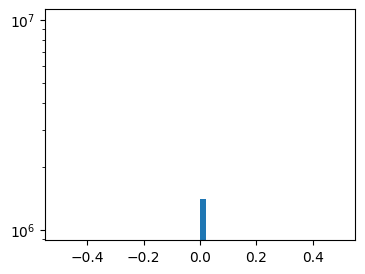

In [10]:
plot_hist(y)

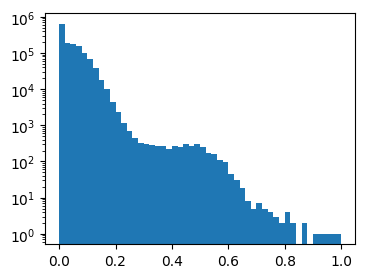

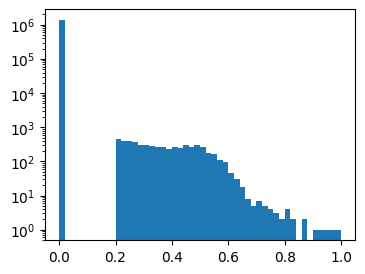

In [8]:
x = load_sample_img()
x = (x - x.min()) / (x.max() - x.min())
plot_hist(x)

x_post = post_process(x, prob_threshold = 0.2, size_threshold = 10)
plot_hist(x_post)

prob_threshold: 0.1, size_threshold: 50


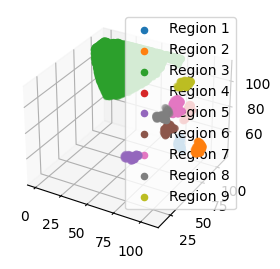

prob_threshold: 0.2, size_threshold: 10


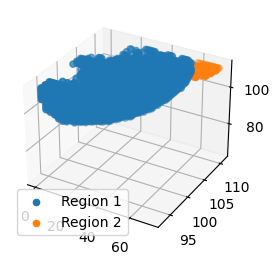

prob_threshold: 0.2, size_threshold: 20


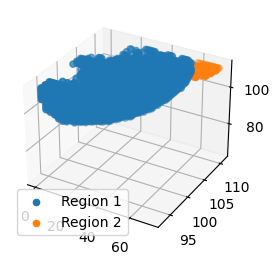

prob_threshold: 0.2, size_threshold: 30


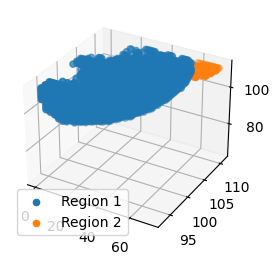

prob_threshold: 0.2, size_threshold: 40


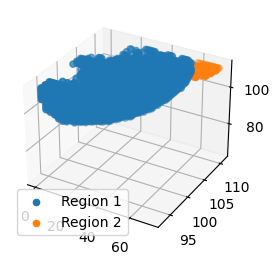

prob_threshold: 0.2, size_threshold: 50


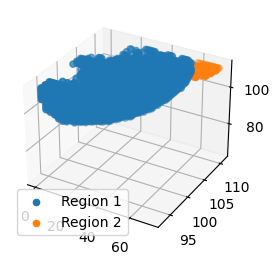

prob_threshold: 0.3, size_threshold: 10


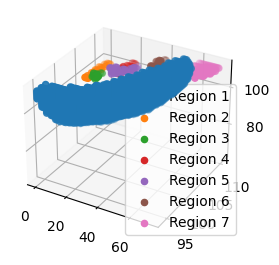

prob_threshold: 0.3, size_threshold: 20


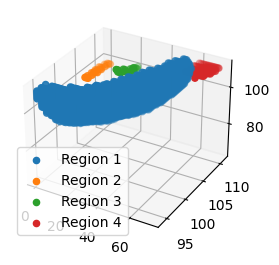

prob_threshold: 0.3, size_threshold: 30


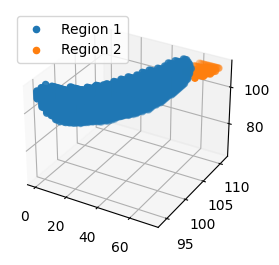

prob_threshold: 0.3, size_threshold: 40


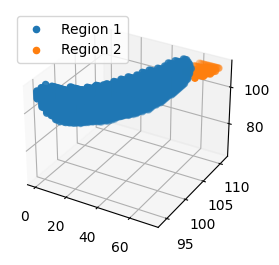

prob_threshold: 0.3, size_threshold: 50


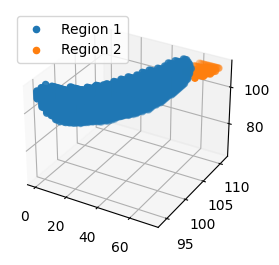

prob_threshold: 0.4, size_threshold: 10


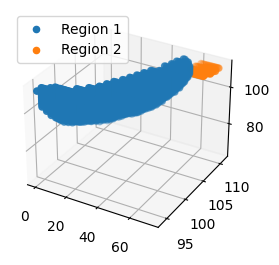

prob_threshold: 0.4, size_threshold: 20


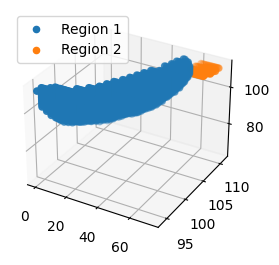

prob_threshold: 0.4, size_threshold: 30


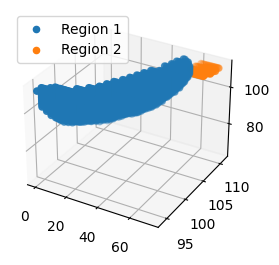

prob_threshold: 0.4, size_threshold: 40


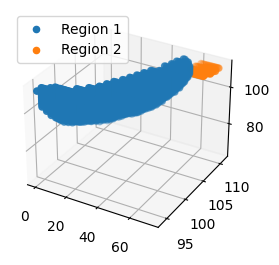

prob_threshold: 0.4, size_threshold: 50


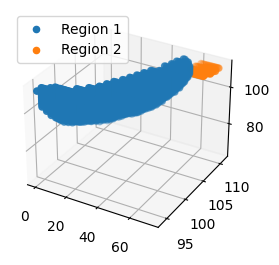

prob_threshold: 0.5, size_threshold: 10


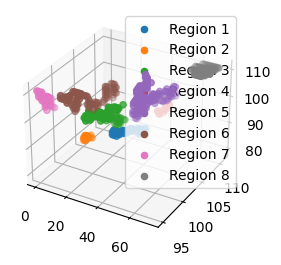

prob_threshold: 0.5, size_threshold: 20


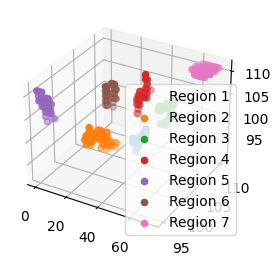

prob_threshold: 0.5, size_threshold: 30


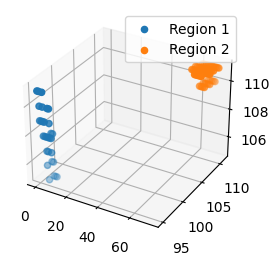

prob_threshold: 0.5, size_threshold: 40


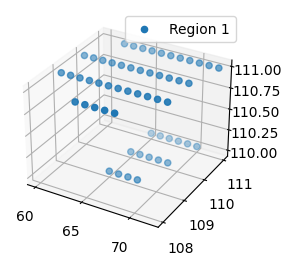

prob_threshold: 0.5, size_threshold: 50


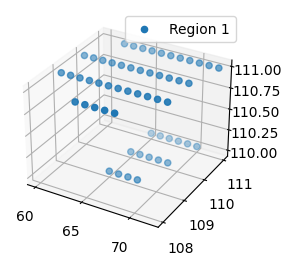

In [7]:
prob_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
size_thresholds = [10, 20, 30, 40, 50]

for prob_threshold in prob_thresholds:
    for size_threshold in size_thresholds:
        x_post = post_process(x, prob_threshold = prob_threshold, size_threshold = size_threshold)
        props, (pred_index, pred_proba, pred_label_code) = find_regions(x_post)
        if len(pred_index) > 10:
            continue
        print(f'prob_threshold: {prob_threshold}, size_threshold: {size_threshold}')
        plot_regions(props)